# True-False news classification using LIAR dataset
### by Tanat Piumsuwan and Worasit Tomduangkaew
### Chiang Mai University

This project is mainly to explore basics to NLP and classification proceses, using the LIAR dataset sourced from Politifact website and provided by William Wang Yang back in 2017 [1].

All credits are given to him for making his dataset widely available.

### Features
1. ID: statement ID in the from of json file.
2. label_6: 6-ways fine-grained label ranging from pants-fire, false, barely-true, half-true, mostly-true, and true.
3. statement
4. speaker
5. speaker_job: speaker's job at the time the statement is given.
6. state: speaker's home state.
7. party: speaker's affiliated party.
8. past counts: for how statements given by the speaker, including in this dataset, are labeled in the past.
9. context: where and how the statement is given.

### Reference
[1] W. Y. Wang, “‘Liar, Liar Pants on Fire’: A New Benchmark Dataset for Fake News Detection.” arXiv, 2017. doi: 10.48550/ARXIV.1705.00648.



In [1]:
# Important libaries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk

In [2]:
# Read TSV data
columns = ["ID", "label_6", "statement", "subject", "speaker", "speaker_job", "state", "party", "pof_count", "false_count", "barelytrue_count", "halftrue_count", "mostlytrue_count", "context"]
train_data = pd.read_table("/kaggle/input/LIARbyYang/train.tsv", header = None, names = columns)
v_data = pd.read_table("/kaggle/input/LIARbyYang/valid.tsv", header = None, names = columns)
test_data = pd.read_table("/kaggle/input/LIARbyYang/test.tsv", header = None, names = columns)


Here we do not want to merge the three tables provided. Next, check the data:

In [3]:
train_data.head(10)

,ID,label_6,statement,subject,speaker,speaker_job,state,party,pof_count,false_count,barelytrue_count,halftrue_count,mostlytrue_count,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
5,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
7,153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa."
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website
9,9741.json,mostly-true,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video


In [4]:
train_data.shape

(10240, 14)

# Relabel

We want to merge the labels from 6-ways to 2 and 3-ways, while keeping the original 6-ways labels for the benchmark.

In [5]:
merger_2 = { 'pants-fire' : 0,
           'false' : 0,
           'barely-true': 0,
           'half-true': 0,
           'mostly-true': 1,
           'true': 1}
merger_3 = { 'pants-fire' : 0,
           'false' : 0,
           'barely-true': 1,
           'half-true': 1,
           'mostly-true': 2,
           'true': 2}
merger_6 = { 'pants-fire' : 0,
           'false' : 1,
           'barely-true': 2,
           'half-true': 3,
           'mostly-true': 4,
           'true': 5}

# training set
train_data['label_2'] = train_data["label_6"].map(merger_2)
train_data['label_3'] = train_data["label_6"].map(merger_3)
train_data["label_6"].replace(merger_6, inplace = True)

# cross validation set
v_data['label_2'] = v_data["label_6"].map(merger_2)
v_data['label_3'] = v_data["label_6"].map(merger_3)
v_data["label_6"].replace(merger_6, inplace = True)

# test set
test_data['label_2'] = test_data["label_6"].map(merger_2)
test_data['label_3'] = test_data["label_6"].map(merger_3)
test_data["label_6"].replace(merger_6, inplace = True)

# check
train_data.head(10)

,ID,label_6,statement,subject,speaker,speaker_job,state,party,pof_count,false_count,barelytrue_count,halftrue_count,mostlytrue_count,context,label_2,label_3
0,2635.json,1,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0,0
1,10540.json,3,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,0,1
2,324.json,4,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,1,2
3,1123.json,1,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,0,0
4,9028.json,3,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,0,1
5,12465.json,5,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,1,2
6,2342.json,2,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.,0,1
7,153.json,3,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.",0,1
8,5602.json,3,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website,0,1
9,9741.json,4,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video,1,2


# Bag of Words Process

In [6]:
# tokenization processes
from nltk.corpus import stopwords
import string
from nltk.tokenize import WhitespaceTokenizer as w_tokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
stemmer=SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

# remove stopwords
def remove_stopwords(list_of_tokens):
    new_list_of_tokens = [w for w in list_of_tokens if not w.lower() in stop_words]
    return new_list_of_tokens

# remove punctutations and tokens with less than two in length
def remove_punctuations_shortwords(list_of_tokens):
    translation = str.maketrans('', '', string.punctuation)
    new_list_of_tokens = [tokens.translate(translation) for tokens in list_of_tokens if len(tokens.translate(translation))>=3]
    return new_list_of_tokens

def tokenize_and_stem(Pandas_Series):
    Pandas_Series = Pandas_Series.replace('\d+', '', regex=True) # remove numbers
    Pandas_Series = Pandas_Series.apply(nltk.word_tokenize) # tokenize statement
    Pandas_Series = Pandas_Series.apply(remove_stopwords) # remove stopwords
    Pandas_Series = Pandas_Series.apply(remove_punctuations_shortwords) # remove punctutations and tokens with less than two in length
    Pandas_Series = Pandas_Series.apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
    return Pandas_Series

In [7]:
train_data['stemmed_statement_token'] = tokenize_and_stem(train_data['statement']) # Process statement strings

See sentence length distribution:

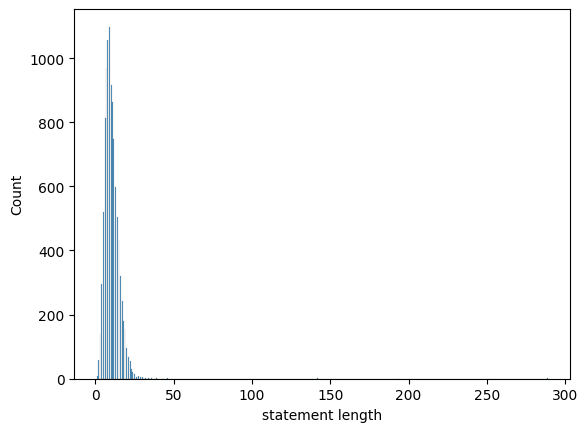

In [8]:
sns.histplot(train_data['stemmed_statement_token'].str.len())
plt.xlabel('statement length')
plt.show()

One can see that there are some outlier sentences that exceed 50 tokens. Our approach is not to get rid of their records, but to exclude them from the CountVecterizer fitting. To do that, we keep the index of instances with statements having too much tokens.

In [9]:
statement_index_tofit = train_data['stemmed_statement_token'].str.len() < 50
train_data[-statement_index_tofit] # instances with very long statements

,ID,label_6,statement,subject,speaker,speaker_job,state,party,pof_count,false_count,barelytrue_count,halftrue_count,mostlytrue_count,context,label_2,label_3,stemmed_statement_token
1280,1606.json,4,"Hospitals, doctors, MRIs, surgeries and so for...","elections,ethics,states",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,a debate on Fox News Sunday,1,2,"[hospit, doctor, mris, surgeri, forth, extens,..."
6119,1993.json,5,Georgia has the most restrictive ballot access...,crime,dan-gelber,NaN,Florida,democrat,2.0,2.0,1.0,3.0,0.0,his campaign blog,1,2,"[georgia, restrict, ballot, access, law, count..."
7550,1720.json,1,The vast majority of the money I got was from ...,"stimulus,transportation",bobby-jindal,Governor of Louisiana,Louisiana,republican,0.0,1.0,4.0,4.0,0.0,the Republican response to Obama's speech to C...,0,0,"[vast, major, money, got, small, donor, across..."


Apply CountVectorizer, ignore the first few rendundant words and words that appear only once.

In [10]:
# untokenized the tokens first
# this is done due to some conflict with the CountVectorizer arguement regarding its analyzer
# otherwise CountVectorizer ngrams could not be used, making the task complicated
train_data["stemmed_statement_token"] = train_data["stemmed_statement_token"].apply(TreebankWordDetokenizer().detokenize) 

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
 
v_statement = CountVectorizer(analyzer= 'word', max_df = 1.0 ,min_df = 2, ngram_range = (2,2)) # need analyzer=lambda x: x to disable the analyzer, since the input is pandas series of lists.
# without cutting out via correlation, it is found that bigram at min_df=2 performs the best
v_statement.fit(train_data["stemmed_statement_token"][statement_index_tofit])
vectors = v_statement.transform(train_data["stemmed_statement_token"])

def new_features(X, string, vectorizer):
    new_features = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out()) # Get new features from countvectorizer
    if type(new_features.columns[0]) == tuple:
        new_features.rename(columns='_'.join, inplace=True)
    new_features.columns = string + '_' + new_features.columns # add prefix to the column names
    return new_features

statement_vector = new_features(vectors, 'st', v_statement)

In [12]:
statement_vector.columns

Index(['st_aaa credit', 'st_aaron bean', 'st_abil fight', 'st_abl buy',
       'st_abl creat', 'st_abl get', 'st_abl make', 'st_abl stay',
       'st_abl vote', 'st_abolish depart',
       ...
       'st_your white', 'st_your work', 'st_youth unemploy', 'st_youv got',
       'st_youv seen', 'st_zack space', 'st_zero job', 'st_zika fund',
       'st_zika virus', 'st_zip code'],
      dtype='object', length=9726)

In [13]:
print(np.abs(statement_vector.corrwith(train_data['label_6'],method= 'pearson')).nlargest(n=10))

st_barack obama       0.064168
st_scott walker       0.052809
st_say barack         0.048593
st_gov scott          0.045753
st_health care        0.044960
st_govern takeov      0.043720
st_care law           0.043625
st_end medicar        0.040528
st_nation debt        0.039177
st_hillari clinton    0.038304
dtype: float64


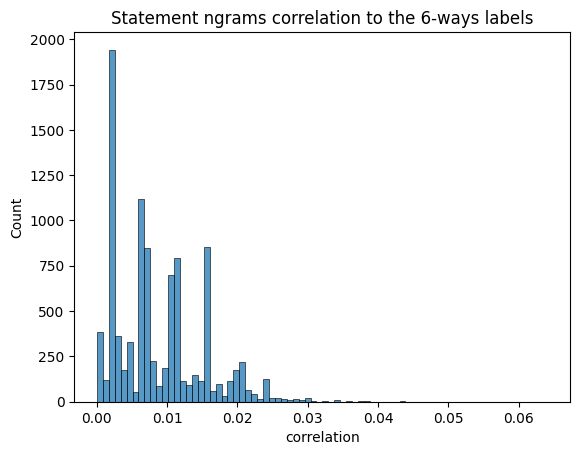

In [14]:
sns.histplot(np.abs(statement_vector.corrwith(train_data['label_6'],method= 'pearson')))
plt.xlabel('correlation')
plt.title('Statement ngrams correlation to the 6-ways labels')
plt.show()

After some investigation, not cutting out further features via correlation yields better result.

In [15]:
statement_corr_cut = False
if statement_corr_cut:
    statement_corr_threshold = 0.0002 # the correlation threshold
    statement_mask = np.abs(statement_vector.corrwith(train_data['label_6'],method= 'pearson'))>statement_corr_threshold
    statement_vector = statement_vector.loc[:,statement_mask]

Merge new features

In [16]:
train_data2 = pd.concat([train_data,statement_vector],axis=1)

Do the same for context. But there are 102 null present, drop them first.

In [17]:
sum(train_data2['context'].isnull())

102

Suppose null value for the context is caused by unknown source, replace them with "unknown".

In [18]:
# fill null context
train_data2["context"].fillna(value = "unknown", inplace=True)

In [19]:
train_data2['stemmed_context_token'] = tokenize_and_stem(train_data2['context']) # Process context strings

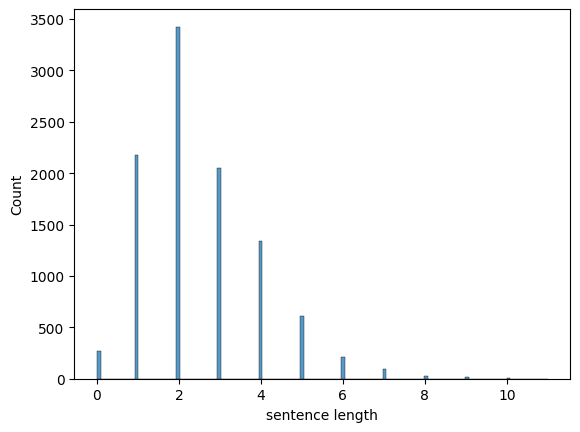

In [20]:
sns.histplot(train_data2['stemmed_context_token'].str.len())
plt.xlabel('sentence length')
plt.show()

Apply vectorizer for contexts containing less than 9 tokens:

In [21]:
context_index_tofit = train_data2['stemmed_context_token'].str.len() < 9

In [22]:
# untokenized the tokens first
# this is done due to some conflict with the CountVectorizer arguement regarding its analyzer
# otherwise CountVectorizer ngrams could not be used, making the task complicated
train_data2["stemmed_context_token"] = train_data2["stemmed_context_token"].apply(TreebankWordDetokenizer().detokenize) 

In [23]:
v_context = CountVectorizer(analyzer='word', max_df = 1.0 ,min_df = 2, ngram_range = (2,2)) # need analyzer=lambda x: x to disable the analyzer, since the input is pandas series of lists.
# without cutting out via correlation, it is found that 1gram at min_df=2  performs the best
v_context.fit(train_data2['stemmed_context_token'][context_index_tofit])
vectors = v_context.transform(train_data2['stemmed_context_token'])
context_vector = new_features(vectors, 'ct', v_context)

In [24]:
context_vector.columns

Index(['ct_abc insid', 'ct_abc interview', 'ct_abc news', 'ct_abc this',
       'ct_abc view', 'ct_abc week', 'ct_aboard air', 'ct_accept speech',
       'ct_action confer', 'ct_address democrat',
       ...
       'ct_written dick', 'ct_written statement', 'ct_written testimoni',
       'ct_written tom', 'ct_york citi', 'ct_york post', 'ct_york time',
       'ct_youngstown ohio', 'ct_youtub attack', 'ct_youtub video'],
      dtype='object', length=1548)

In [25]:
print(np.abs(context_vector.corrwith(train_data2['label_6'],method= 'pearson')).nlargest(n=10))

ct_chain email        0.111548
ct_post internet      0.049176
ct_mani peopl         0.048652
ct_democrat nation    0.043107
ct_state union        0.039726
ct_messag via         0.038343
ct_via internet       0.038343
ct_social media       0.037953
ct_limbaugh show      0.035955
ct_rush limbaugh      0.035955
dtype: float64


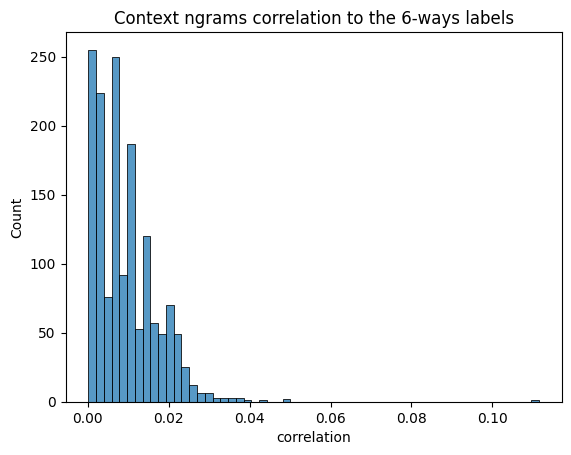

In [26]:
sns.histplot(np.abs(context_vector.corrwith(train_data2['label_6'],method= 'pearson')))
plt.xlabel('correlation')
plt.title('Context ngrams correlation to the 6-ways labels')
plt.show()

In [27]:
context_corr_cut = True
if context_corr_cut:
    context_corr_threshold = 0.1 # the correlation threshold
    context_mask = np.abs(context_vector.corrwith(train_data2['label_6'],method= 'pearson'))>context_corr_threshold
    context_vector = context_vector.loc[:,context_mask]

In [28]:
train_data3 = pd.concat([train_data2,context_vector],axis=1)
train_data3.shape

(10240, 9745)

Do the same for subject. Now, the tokens are separated by commas in this case. Thus, change them to spaces before tokenizing them.

In [29]:
sum(train_data3['subject'].isnull()) #check number of nulls

2

In [30]:
train_data3[train_data3['subject'].isnull()]

,ID,label_6,statement,subject,speaker,speaker_job,state,party,pof_count,false_count,...,st_youth unemploy,st_youv got,st_youv seen,st_zack space,st_zero job,st_zika fund,st_zika virus,st_zip code,stemmed_context_token,ct_chain email
2142,638.json,1,The fact is that although we have had a presid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,unknown,0
9375,1626.json,1,"Joe, I keep hearing you every morning talking ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,unknown,0


There are two nulls to get rid of. Replace them with "unknown".

In [31]:
# fill null subject
train_data3["subject"].fillna(value = "unknown", inplace=True)

Apply defined tokenizer:

In [32]:
train_data3['subject'].replace(',',' ',regex=True,inplace=True)  # turn commas to blank spaces
train_data3['stemmed_subject_token'] = tokenize_and_stem(train_data3['subject']) # Process subject strings

Apply CountVectorizer:

In [33]:
v_subject = CountVectorizer(analyzer=lambda x: x, max_df = 1.0 ,min_df = 1) # need analyzer=lambda x: x to disable the analyzer, since the input is pandas series of lists.
vectors = v_subject.fit_transform(train_data3['stemmed_subject_token'])
subject_vector = new_features(vectors, 'sj', v_subject)

In [34]:
subject_vector.columns

Index(['sj_abcnewsweek', 'sj_abort', 'sj_afghanistan', 'sj_afterthefact',
       'sj_agricultur', 'sj_alcohol', 'sj_anim', 'sj_autism', 'sj_bankruptci',
       'sj_basebal',
       ...
       'sj_unknown', 'sj_urban', 'sj_veteran', 'sj_votingrecord', 'sj_water',
       'sj_wealth', 'sj_weather', 'sj_welfar', 'sj_women', 'sj_worker'],
      dtype='object', length=141)

In [35]:
print(np.abs(subject_vector.corrwith(train_data3['label_6'],method= 'pearson')).nlargest(n=10))

sj_healthcar           0.067869
sj_religion            0.061325
sj_obamabirthcertif    0.056985
sj_economi             0.045675
sj_medicar             0.045119
sj_educ                0.040666
sj_immigr              0.035748
sj_fakenew             0.032807
sj_worker              0.032375
sj_incom               0.030851
dtype: float64


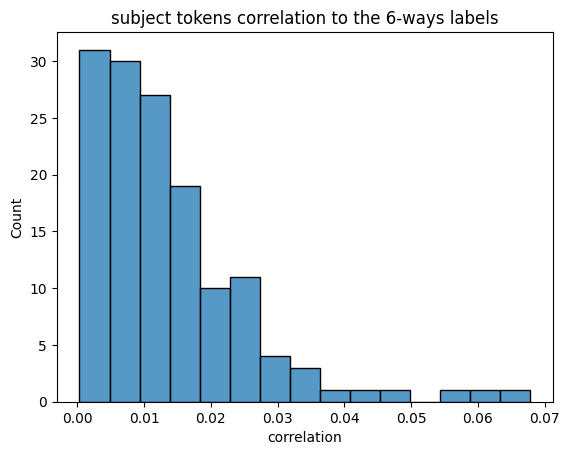

In [36]:
sns.histplot(np.abs(subject_vector.corrwith(train_data3['label_6'],method= 'pearson')))
plt.xlabel('correlation')
plt.title('subject tokens correlation to the 6-ways labels')
plt.show()

In [37]:
subject_corr_cut = True
if subject_corr_cut:
    subject_corr_threshold = 0.06 # the correlation threshold
    subject_mask = np.abs(subject_vector.corrwith(train_data3['label_6'],method= 'pearson'))>subject_corr_threshold
    subject_vector = subject_vector.loc[:,subject_mask]

In [38]:
train_data4 = pd.concat([train_data3,subject_vector],axis=1)

Drop original columns and get the final DataFrame:

In [39]:
train_data4.drop(columns=['statement', 'stemmed_statement_token','context', 'stemmed_context_token','subject', 'stemmed_subject_token'], inplace=True)

In [40]:
train_data4.shape

(10240, 9742)

In [41]:
train_data4.head(10)

,ID,label_6,speaker,speaker_job,state,party,pof_count,false_count,barelytrue_count,halftrue_count,...,st_youv got,st_youv seen,st_zack space,st_zero job,st_zika fund,st_zika virus,st_zip code,ct_chain email,sj_healthcar,sj_religion
0,2635.json,1,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,10540.json,3,scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,324.json,4,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,...,0,0,0,0,0,0,0,0,0,0
3,1123.json,1,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,...,0,0,0,0,0,0,0,0,1,0
4,9028.json,3,charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,...,0,0,0,0,0,0,0,0,0,0
5,12465.json,5,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,...,0,0,0,0,0,0,0,0,0,0
6,2342.json,2,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
7,153.json,3,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,...,0,0,0,0,0,0,0,0,0,0
8,5602.json,3,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,9741.json,4,duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


# Training Data Cleaning and Encoding

In [42]:
print(np.sum(train_data4.isnull(),axis = 0)) 

ID                   0
label_6              0
speaker              2
speaker_job       2898
state             2210
                  ... 
st_zika virus        0
st_zip code          0
ct_chain email       0
sj_healthcar         0
sj_religion          0
Length: 9742, dtype: int64


First, we ignore the speaker's name and focus on their past speech counts. Even if the counts themselves may not determine if they will speak the truth in the future or not. But in terms of our work, they can serve as vectors determining who is which person. Then, for speaker jobs and their states, we deem that they are less likely to contribute to the model comparing to other atributes. Thus, let's verify if they are really the features to get rid of.

In [43]:
# fill null for speaker's information with 'unknown'

train_data4['speaker_job'].fillna('unknown', inplace = True)
train_data4['state'].fillna('unknown', inplace = True)

In [44]:
print('Speaker\'s job and states absolute correlation to 6-ways label:', np.abs(train_data4[['speaker_job','state']].corrwith(train_data4['label_6'],method= 'kendall')))
print('Speaker\'s jobs and states absolute correlation to 3-ways label:', np.abs(train_data4[['speaker_job','state']].corrwith(train_data4['label_3'],method= 'kendall')))
print('Speaker\'s jobs and states absolute correlation to 2-ways label:', np.abs(train_data4[['speaker_job','state']].corrwith(train_data4['label_2'],method= 'kendall')))

Speaker's job and states absolute correlation to 6-ways label: speaker_job    0.026780
state          0.070812
dtype: float64
Speaker's jobs and states absolute correlation to 3-ways label: speaker_job    0.020093
state          0.070897
dtype: float64
Speaker's jobs and states absolute correlation to 2-ways label: speaker_job    0.021696
state          0.055747
dtype: float64


Check if there is some individual feartures that are useful.

In [45]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(handle_unknown = 'ignore') #ignore tells the encoder to ignore new categories by encoding them with 0's
vectors = onehot.fit_transform(np.array(train_data4[['speaker_job','state']]))
speaker_vectors = new_features(vectors, 'speaker', onehot)

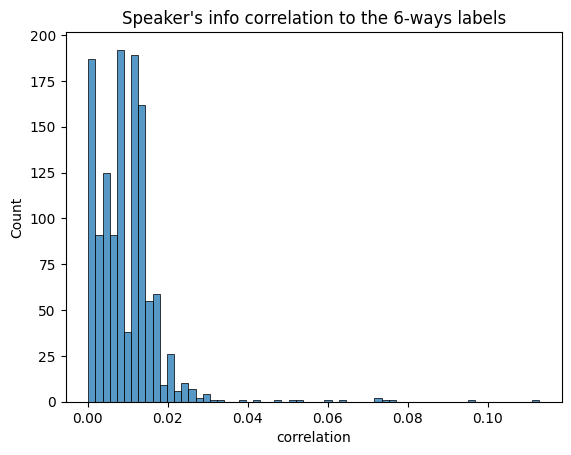

In [46]:
sns.histplot(np.abs(speaker_vectors.corrwith(train_data4['label_6'],method= 'pearson')))
plt.xlabel('correlation')
plt.title('Speaker\'s info correlation to the 6-ways labels')
plt.show()

In [47]:
print('Top 10 speaker\'s info absolute correlation to 6-ways label:', np.abs(speaker_vectors.corrwith(train_data4['label_6'],method= 'pearson')).nlargest(n=10))

Top 10 speaker's info absolute correlation to 6-ways label: speaker_x0_President-Elect           0.112808
speaker_x1_unknown                   0.095835
speaker_x0_President                 0.075831
speaker_x0_U.S. Senator              0.073664
speaker_x0_unknown                   0.073348
speaker_x1_Illinois                  0.072062
speaker_x1_Ohio                      0.063330
speaker_x0_Presidential candidate    0.060856
speaker_x0_Radio host                0.052725
speaker_x0_Social media posting      0.051204
dtype: float64


One can see that the correlations to the target class do not exceed 0.034; thus, confirm our assumption that they are irrelavant. However, there are a few outlier to be kept. Proceed to some columns with correlation threshold and the original columns, together with statement ID and speaker's name.

In [48]:
keepspeaker_info = True
if keepspeaker_info:
    speaker_info_corr_threshold = 0.05 # the correlation threshold
    train_data4 = pd.concat([train_data4,speaker_vectors.loc[:,np.abs(speaker_vectors.corrwith(train_data4['label_6'],method= 'pearson'))>speaker_info_corr_threshold] ],axis=1)

In [49]:
# drop unnescessary columns
train_data4.drop(columns = ['ID','speaker','speaker_job','state'],inplace = True)

Next, there are some null for the counts and party:

In [50]:
np.sum(train_data4[['pof_count','false_count','barelytrue_count','halftrue_count','mostlytrue_count']].isnull(),axis = 0)

pof_count           2
false_count         2
barelytrue_count    2
halftrue_count      2
mostlytrue_count    2
dtype: int64

In [51]:
np.sum(train_data['party'].isnull(),axis = 0)

2

Assume that these are caused by unknown speaker, simply set them to 0.

In [52]:
train_data4['pof_count'].fillna(0, inplace = True)
train_data4['false_count'].fillna(0, inplace = True)
train_data4['barelytrue_count'].fillna(0, inplace = True)
train_data4['halftrue_count'].fillna(0, inplace = True)
train_data4['mostlytrue_count'].fillna(0, inplace = True)

and assume "unknown" for the null in party.

In [53]:
train_data4['party'].fillna("unknown", inplace = True)

Check the party feature correlation to the target classes:

In [54]:
print('Speaker\'s party absolute correlation to 6-ways label:', np.abs(train_data4['party'].corr(train_data4['label_6'],method= 'kendall')))

Speaker's party absolute correlation to 6-ways label: 0.11078244905872753


Turns out our assumption about the party is wrong. The feature is not as useful as we thought. Nonetheless, let's investigate a little deeper if we can extract any useful feature. First, One-Hot encode party via scikit-learn module:

In [55]:
ohe = OneHotEncoder(handle_unknown = 'ignore') #ignore tells the encoder to ignore new categories by encoding them with 0's
vectors = ohe.fit_transform(np.array(train_data4['party']).reshape(-1, 1))
party_vector = new_features(vectors, 'party', ohe)

In [56]:
print('Top 5 speaker\'s party absolute correlation to 6-ways label:', np.abs(party_vector.corrwith(train_data4['label_6'],method= 'pearson')).nlargest(n=5))
print('Top 5 speaker\'s party absolute correlation to 3-ways label:', np.abs(party_vector.corrwith(train_data4['label_3'],method= 'pearson')).nlargest(n=5))
print('Top 5 speaker\'s party absolute correlation to 2-ways label:', np.abs(party_vector.corrwith(train_data4['label_2'],method= 'pearson')).nlargest(n=5))

Top 5 speaker's party absolute correlation to 6-ways label: party_x0_democrat        0.146585
party_x0_republican      0.094429
party_x0_none            0.071097
party_x0_independent     0.045065
party_x0_organization    0.027233
dtype: float64
Top 5 speaker's party absolute correlation to 3-ways label: party_x0_democrat        0.140405
party_x0_republican      0.098021
party_x0_none            0.056131
party_x0_independent     0.049249
party_x0_organization    0.030884
dtype: float64
Top 5 speaker's party absolute correlation to 2-ways label: party_x0_democrat        0.119210
party_x0_republican      0.094838
party_x0_independent     0.047645
party_x0_organization    0.042038
party_x0_none            0.031807
dtype: float64


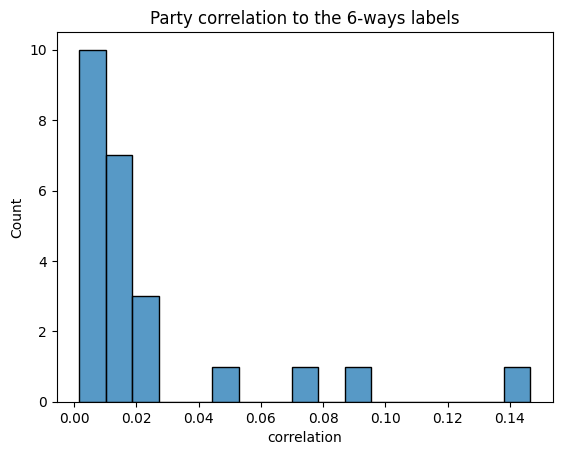

In [57]:
sns.histplot(np.abs(party_vector.corrwith(train_data4['label_6'],method= 'pearson')))
plt.xlabel('correlation')
plt.title('Party correlation to the 6-ways labels')
plt.show()

The Democrat and Republican stand out from the other top 5 parties. Therefore, we decide to keep this in our model.

In [58]:
party_corr_cut = True
if party_corr_cut:
    party_corr_threshold = 0.08 # the correlation threshold
    party_mask = np.abs(party_vector.corrwith(train_data4['label_6'],method= 'pearson'))>party_corr_threshold
    party_vector = party_vector.loc[:,party_mask]

In [59]:
train_data4 = pd.concat([train_data4,party_vector],axis=1)
train_data4.drop(columns=['party'], inplace=True)

In [60]:
train_data4.head(10)

,label_6,pof_count,false_count,barelytrue_count,halftrue_count,mostlytrue_count,label_2,label_3,st_aaa credit,st_aaron bean,...,speaker_x0_Presidential candidate,speaker_x0_Radio host,speaker_x0_Social media posting,speaker_x0_U.S. Senator,speaker_x0_unknown,speaker_x1_Illinois,speaker_x1_Ohio,speaker_x1_unknown,party_x0_democrat,party_x0_republican
0,1,0.0,1.0,0.0,0.0,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3,0.0,0.0,1.0,1.0,0.0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4,70.0,71.0,160.0,163.0,9.0,1,2,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1,7.0,19.0,3.0,5.0,44.0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,3,15.0,9.0,20.0,19.0,2.0,0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,5,0.0,3.0,2.0,5.0,1.0,1,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,2,3.0,1.0,1.0,3.0,1.0,0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7,3,70.0,71.0,160.0,163.0,9.0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8,3,0.0,0.0,1.0,0.0,1.0,0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,4,0.0,0.0,0.0,1.0,0.0,1,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Training, Valdiation and Test Sets Preparation

Apply BoW, vectorizer, and one-hot encoding to v and test set without word counts threshold and cut-offs. Then, mask the columns with ones from the training set, such that the columns that do not appear in the training set are dropped. For columns that do not exist in the v and test set, add them and set their values to zero.

In [61]:
# fill nulls
v_data["subject"].fillna(value = "unknown", inplace=True)
v_data["context"].fillna(value = "unknown", inplace=True)
v_data['party'].fillna("unknown", inplace = True)
test_data["subject"].fillna(value = "unknown", inplace=True)
test_data["context"].fillna(value = "unknown", inplace=True)
test_data['party'].fillna("unknown", inplace = True)

v_data['pof_count'].fillna(0, inplace = True)
v_data['false_count'].fillna(0, inplace = True)
v_data['barelytrue_count'].fillna(0, inplace = True)
v_data['halftrue_count'].fillna(0, inplace = True)
v_data['mostlytrue_count'].fillna(0, inplace = True)

test_data['pof_count'].fillna(0, inplace = True)
test_data['false_count'].fillna(0, inplace = True)
test_data['barelytrue_count'].fillna(0, inplace = True)
test_data['halftrue_count'].fillna(0, inplace = True)
test_data['mostlytrue_count'].fillna(0, inplace = True)

In [62]:
# tokenize statement
v_data["stemmed_statement_token"] = tokenize_and_stem(v_data['statement'])
v_data["stemmed_statement_token"] = v_data["stemmed_statement_token"].apply(TreebankWordDetokenizer().detokenize) 
test_data["stemmed_statement_token"] = tokenize_and_stem(test_data['statement'])
test_data["stemmed_statement_token"] = test_data["stemmed_statement_token"].apply(TreebankWordDetokenizer().detokenize)

# tokenize context
v_data["stemmed_context_token"] = tokenize_and_stem(v_data['context'])
v_data["stemmed_context_token"] = v_data["stemmed_context_token"].apply(TreebankWordDetokenizer().detokenize) 
test_data["stemmed_context_token"] = tokenize_and_stem(test_data['context'])
test_data["stemmed_context_token"] = test_data["stemmed_context_token"].apply(TreebankWordDetokenizer().detokenize) 

# turn commas to blank spaces for subjects
v_data['subject'].replace(',',' ',regex=True,inplace=True) 
test_data['subject'].replace(',',' ',regex=True,inplace=True)  

# tokenize subject
v_data["stemmed_subject_token"] = tokenize_and_stem(v_data['subject'])
test_data["stemmed_subject_token"] = tokenize_and_stem(test_data['subject'])

Apply the countvectorizer based on what we have done for the training set via transform.

In [63]:
def transformtovec(Pandas_Series, prefixstring, vectorizer):
    vectors = vectorizer.transform(Pandas_Series)
    vecdataframe = new_features(vectors, prefixstring, vectorizer)
    return vecdataframe

In [64]:
# Statement
# get new DataFrame
v_statement_vectors = transformtovec(v_data["stemmed_statement_token"], 'st', v_statement)
test_statement_vectors = transformtovec(test_data["stemmed_statement_token"], 'st', v_statement)

if statement_corr_cut:
    v_statement_vectors = v_statement_vectors.loc[:,statement_mask]
    test_statement_vectors = test_statement_vectors.loc[:,statement_mask]

# Context
# get new DataFrame
v_context_vectors = transformtovec(v_data["stemmed_context_token"], 'ct', v_context)
test_context_vectors = transformtovec(test_data["stemmed_context_token"], 'ct', v_context)

if context_corr_cut:
    v_context_vectors = v_context_vectors.loc[:,context_mask]
    test_context_vectors = test_context_vectors.loc[:,context_mask]

# Context
# get new DataFrame
v_subject_vectors = transformtovec(v_data["stemmed_subject_token"], 'sj', v_subject)
test_subject_vectors = transformtovec(test_data["stemmed_subject_token"], 'sj', v_subject)

if subject_corr_cut:
    v_subject_vectors = v_subject_vectors.loc[:,subject_mask]
    test_subject_vectors = test_subject_vectors.loc[:,subject_mask]

In [65]:
# merge the data in the same order as the training set

# cross validation set
v_data = pd.concat([v_data,v_statement_vectors],axis=1)
v_data = pd.concat([v_data,v_context_vectors],axis=1)
v_data = pd.concat([v_data,v_subject_vectors],axis=1)

# test set
test_data = pd.concat([test_data,test_statement_vectors],axis=1)
test_data = pd.concat([test_data,test_context_vectors],axis=1)
test_data = pd.concat([test_data,test_subject_vectors],axis=1)

# drop original and unnecessary columns
v_data.drop(columns=['ID','statement', 'stemmed_statement_token','context', 'stemmed_context_token','subject', 'stemmed_subject_token','speaker'], inplace=True)
test_data.drop(columns=['ID','statement', 'stemmed_statement_token','context', 'stemmed_context_token','subject', 'stemmed_subject_token','speaker'], inplace=True)

Get speaker information vectors

In [66]:
if keepspeaker_info:
    # validation
    vectors = onehot.transform(np.array(v_data[['speaker_job','state']]))
    v_speaker_vectors = new_features(vectors, 'speaker', onehot)
    v_data = pd.concat([v_data,v_speaker_vectors.loc[:,np.abs(speaker_vectors.corrwith(train_data4['label_6'],method= 'pearson'))>speaker_info_corr_threshold] ],axis=1)

    # test
    vectors = onehot.transform(np.array(test_data[['speaker_job','state']]))
    test_speaker_vectors = new_features(vectors, 'speaker', onehot)
    test_data = pd.concat([test_data,test_speaker_vectors.loc[:,np.abs(speaker_vectors.corrwith(train_data4['label_6'],method= 'pearson'))>speaker_info_corr_threshold] ],axis=1)

# drop original and unnecessary columns
v_data.drop(columns=['speaker_job','state'], inplace=True)
test_data.drop(columns=['speaker_job','state'], inplace=True)

Get the Democrat One-Hot Feature:

In [67]:
# validation
vectors = ohe.transform(np.array(v_data['party']).reshape(-1, 1))
v_party_vector = new_features(vectors, 'party', ohe)
v_data.drop(columns=['party'], inplace=True)

# test
vectors = ohe.transform(np.array(test_data['party']).reshape(-1, 1))
test_party_vector = new_features(vectors, 'party', ohe)
test_data.drop(columns=['party'], inplace=True)

if party_corr_cut:
    v_party_vector = v_party_vector.loc[:,party_mask]
    test_party_vector = test_party_vector.loc[:,party_mask]

v_data = pd.concat([v_data,v_party_vector],axis = 1)
test_data = pd.concat([test_data,test_party_vector],axis = 1)

Lastly, properly identify the independent and dependent variables.

In [68]:
# features
X_train = train_data4.drop(columns = ['label_2','label_3','label_6'])
X_v = v_data.drop(columns = ['label_2','label_3','label_6'])
X_test = test_data.drop(columns = ['label_2','label_3','label_6'])

# targets
y_train = train_data4[['label_2','label_3','label_6']]
y_v = v_data[['label_2','label_3','label_6']]
y_test = test_data[['label_2','label_3','label_6']]

# Models

Generate three types of model from the data.

In [69]:
label = 2 # label to metric: 0,1, 2 for 2, 3 and 6 ways respectively

In [70]:
dropctfeature = False # drop subject for model testing
dropsjfeature = False # drop subject for model testing

print(X_train.shape)
if dropctfeature:
    drop = list(X_train.filter(regex='ct'))
    X_train.drop(columns = drop, inplace = True)
    X_v.drop(columns = drop, inplace = True)
    X_test.drop(columns = drop, inplace = True)

if dropsjfeature:
    drop = list(X_train.filter(regex='sj'))
    X_train.drop(columns = drop, inplace = True)
    X_v.drop(columns = drop, inplace = True)
    X_test.drop(columns = drop, inplace = True)
print(X_train.shape)

(10240, 9746)
(10240, 9746)


In [71]:
from sklearn.model_selection import cross_val_score

## Naive Bayes


In [72]:
BuildNB = True

In [73]:
from sklearn.naive_bayes import GaussianNB

if BuildNB:
    gnb = GaussianNB()
    gnb.fit(X_train, y_train.iloc[:,label])
    cv_score = cross_val_score(gnb, X_train, y_train.iloc[:,label], cv=5)
    y_pred_v = gnb.predict(X_v)
    y_pred_test = gnb.predict(X_test)

In [74]:
from sklearn import metrics
if BuildNB:
    print('cv 5 fold :', cv_score.mean())
    print('validation :', metrics.accuracy_score(y_v.iloc[:,label], y_pred_v))
    print('test :', metrics.accuracy_score(y_test.iloc[:,label], y_pred_test))

cv 5 fold : 0.20908203125
validation : 0.1674454828660436
test : 0.1957379636937648


The Naive Bayes model perform very bad.

## KNN

In [75]:
BuildKNN = True

In [76]:
from sklearn.neighbors import KNeighborsClassifier

if BuildKNN:
    k_range = list(range(1, 182,20))
    scores_train = []
    scores = []
    scores2 = []
    score_cv = []
    for i in k_range:
        knn = KNeighborsClassifier(n_neighbors=i,weights = 'distance')
        knn.fit(X_train, y_train)
        y_pred_t = knn.predict(X_train)
        y_pred = knn.predict(X_v)
        y_pred2 = knn.predict(X_test)
        cv_scores = cross_val_score(knn, X_train, y_train.iloc[:,label], cv=5)
        scores_train.append(metrics.accuracy_score(y_train.iloc[:,label], y_pred_t[:,label]))
        scores.append(metrics.accuracy_score(y_v.iloc[:,label], y_pred[:,label]))
        score_cv.append(cv_scores.mean())
        scores2.append(metrics.accuracy_score(y_test.iloc[:,label], y_pred2[:,label]))


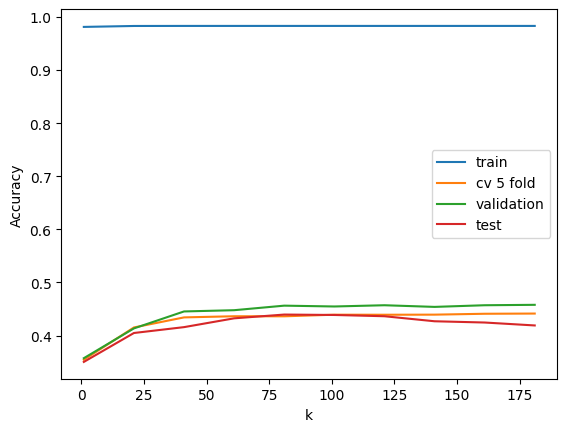

[[  1.       35.04341]
 [ 21.       40.48934]
 [ 41.       41.59432]
 [ 61.       43.25178]
 [ 81.       43.96212]
 [101.       43.88319]
 [121.       43.64641]
 [141.       42.69929]
 [161.       42.46251]
 [181.       41.91002]]


In [77]:
if BuildKNN:
    plt.plot(k_range, scores_train, label = 'train')
    plt.plot(k_range, score_cv, label = 'cv 5 fold')
    plt.plot(k_range, scores, label = 'validation')
    plt.plot(k_range, scores2, label = 'test')
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.show()
    print(np.transpose(np.array([k_range,np.around(scores2,7)*100])))

In [78]:
if BuildKNN:
    # scale down the range to find the most optimal k
    k_range = list(range(70, 90,1))
    scores_train = []
    scores = []
    scores2 = []
    score_cv = []
    for i in k_range:
        knn = KNeighborsClassifier(n_neighbors=i,weights = 'distance')
        knn.fit(X_train, y_train)
        y_pred_t = knn.predict(X_train)
        y_pred = knn.predict(X_v)
        y_pred2 = knn.predict(X_test)
        cv_scores = cross_val_score(knn, X_train, y_train.iloc[:,label], cv=5)
        scores_train.append(metrics.accuracy_score(y_train.iloc[:,label], y_pred_t[:,label]))
        scores.append(metrics.accuracy_score(y_v.iloc[:,label], y_pred[:,label]))
        score_cv.append(cv_scores.mean())
        scores2.append(metrics.accuracy_score(y_test.iloc[:,label], y_pred2[:,label]))


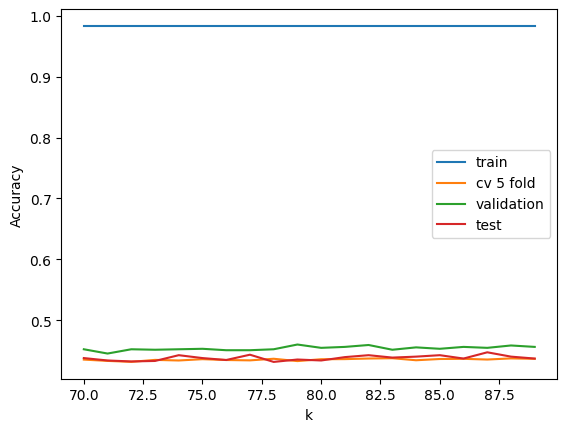

[[70.      43.80426]
 [71.      43.40963]
 [72.      43.25178]
 [73.      43.3307 ]
 [74.      44.27782]
 [75.      43.80426]
 [76.      43.48856]
 [77.      44.35675]
 [78.      43.17285]
 [79.      43.56748]
 [80.      43.40963]
 [81.      43.96212]
 [82.      44.27782]
 [83.      43.88319]
 [84.      44.04104]
 [85.      44.27782]
 [86.      43.72534]
 [87.      44.75138]
 [88.      44.04104]
 [89.      43.72534]]


In [79]:
if BuildKNN:
    plt.plot(k_range, scores_train, label = 'train')
    plt.plot(k_range, score_cv, label = 'cv 5 fold')
    plt.plot(k_range, scores, label = 'validation')
    plt.plot(k_range, scores2, label = 'test')
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.show()
    print(np.transpose(np.array([k_range,np.around(scores2,7)*100])))

0.44751381215469616


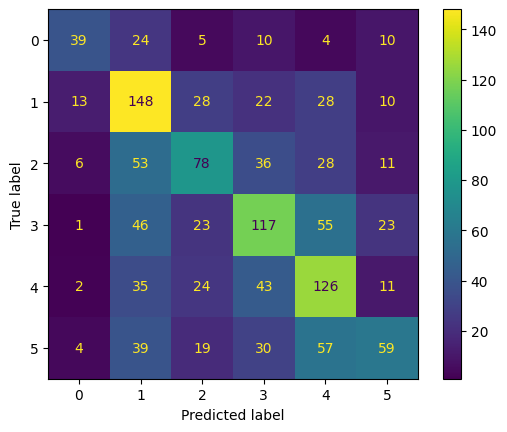

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# best k at k =87
if BuildKNN:
    knn = KNeighborsClassifier(n_neighbors=87,weights = 'distance')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    cm = confusion_matrix(y_test.iloc[:,label],y_pred[:,label], labels=knn.classes_[label])
    print(metrics.accuracy_score(y_test.iloc[:,label], y_pred[:,label]))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn.classes_[label])
    disp.plot()
    plt.show()

## Logistic Regression

In [81]:
BuildLR = True

In [82]:
from sklearn.linear_model import LogisticRegression

if BuildLR:
    order_range = np.arange(-4,1,1)
    c_range = 10.0**order_range
    scoreslr_train = []
    scoreslr = []
    scoreslr2 = []
    score_cvlr = []
    for c in c_range:
        logreg = LogisticRegression(random_state=0,C=c,max_iter = 3000)
        logreg.fit(X_train, y_train.iloc[:,label])
        y_pred_t = logreg.predict(X_train)
        y_pred = logreg.predict(X_test)
        y_pred_v = logreg.predict(X_v)
        cv_scores = cross_val_score(logreg, X_train, y_train.iloc[:,label], cv=2)
        scoreslr_train.append(metrics.accuracy_score(y_train.iloc[:,label], y_pred_t))
        scoreslr.append(metrics.accuracy_score(y_test.iloc[:,label], y_pred))
        scoreslr2.append(metrics.accuracy_score(y_v.iloc[:,label], y_pred_v))
        score_cvlr.append(cv_scores.mean())

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

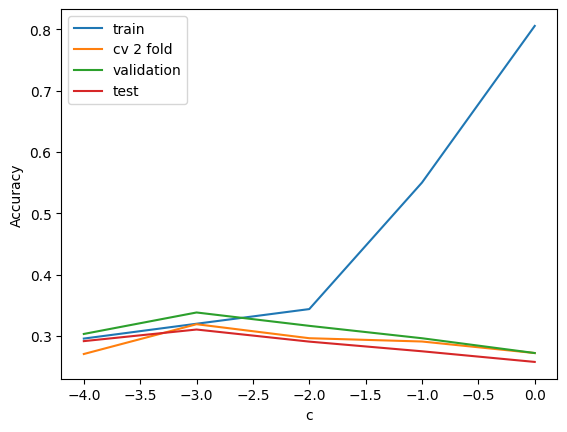

[[-4.      29.12391]
 [-3.      31.01815]
 [-2.      29.04499]
 [-1.      27.46646]
 [ 0.      25.73007]]


In [83]:
if BuildLR:
    plt.plot(order_range, scoreslr_train, label = 'train')
    plt.plot(order_range, score_cvlr, label = 'cv 2 fold')
    plt.plot(order_range, scoreslr2, label = 'validation')
    plt.plot(order_range, scoreslr, label = 'test')
    plt.xlabel('c')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    print(np.transpose(np.array([order_range,np.around(scoreslr,7)*100])))

Not just we encounter non convergence problem for this model. Best Logistic Regression model at around c = 10^(-3) could not even come close to the KNN model. This model is hard to be optimize possibly because the huge amount of features.

# Final KNN Model

Consider that there are some highly correlated columns from states included in the features. While in fact, discrimating someone from any state that they tend to lie more does not make sense. Thus, we will remove them to see if there is any improvement.

In [84]:
X_train.filter(regex='speaker_x1') # there are columns for speaker from 

,speaker_x1_Illinois,speaker_x1_Ohio,speaker_x1_unknown
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,0.0
...,...,...,...
10235,0.0,0.0,0.0
10236,0.0,0.0,0.0
10237,0.0,0.0,0.0
10238,0.0,0.0,0.0


In [85]:
# drop state columns
drop = list(X_train.filter(regex='speaker_x1'))
X_train2 = X_train.drop(columns = drop)
X_v2 = X_v.drop(columns = drop)
X_test2 = X_test.drop(columns = drop)

In [86]:
BuildfinalKNN = True

In [87]:
if BuildfinalKNN:
    k_range = list(range(1, 182,20))
    scores_train_final = []
    scores_final = []
    scores2_final = []
    score_cv_final = []
    for i in k_range:
        knn = KNeighborsClassifier(n_neighbors=i,weights = 'distance')
        knn.fit(X_train2, y_train)
        y_pred_t = knn.predict(X_train2)
        y_pred = knn.predict(X_v2)
        y_pred2 = knn.predict(X_test2)
        cv_scores = cross_val_score(knn, X_train2, y_train.iloc[:,label], cv=5)
        scores_train_final.append(metrics.accuracy_score(y_train.iloc[:,label], y_pred_t[:,label]))
        scores_final.append(metrics.accuracy_score(y_v.iloc[:,label], y_pred[:,label]))
        score_cv_final.append(cv_scores.mean())
        scores2_final.append(metrics.accuracy_score(y_test.iloc[:,label], y_pred2[:,label]))


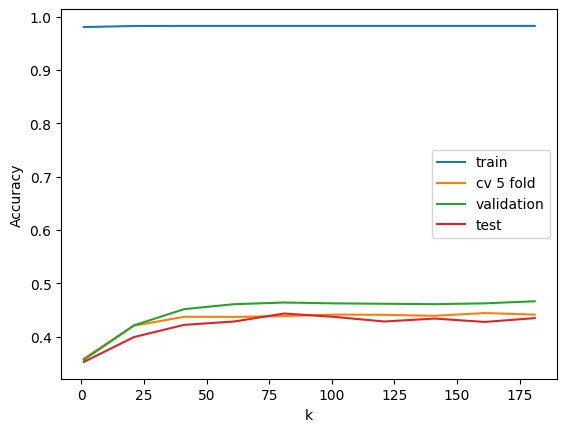

[[  1.       35.28019]
 [ 21.       39.93686]
 [ 41.       42.22573]
 [ 61.       42.85714]
 [ 81.       44.35675]
 [101.       43.72534]
 [121.       42.85714]
 [141.       43.40963]
 [161.       42.77822]
 [181.       43.48856]]


In [88]:
if BuildfinalKNN:
    plt.plot(k_range, scores_train_final, label = 'train')
    plt.plot(k_range, score_cv_final, label = 'cv 5 fold')
    plt.plot(k_range, scores_final, label = 'validation')
    plt.plot(k_range, scores2_final, label = 'test')
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.show()
    print(np.transpose(np.array([k_range,np.around(scores2_final,7)*100])))

In [89]:
if BuildfinalKNN:
    # scale down the range to find the most optimum k
    k_range = list(range(70, 90, 1))
    scores_train_final = []
    scores_final = []
    scores2_final = []
    score_cv_final = []
    for i in k_range:
        knn = KNeighborsClassifier(n_neighbors=i,weights = 'distance')
        knn.fit(X_train2, y_train)
        y_pred_t = knn.predict(X_train2)
        y_pred = knn.predict(X_v2)
        y_pred2 = knn.predict(X_test2)
        cv_scores = cross_val_score(knn, X_train2, y_train.iloc[:,label], cv=5)
        scores_train_final.append(metrics.accuracy_score(y_train.iloc[:,label], y_pred_t[:,label]))
        scores_final.append(metrics.accuracy_score(y_v.iloc[:,label], y_pred[:,label]))
        score_cv_final.append(cv_scores.mean())
        scores2_final.append(metrics.accuracy_score(y_test.iloc[:,label], y_pred2[:,label]))


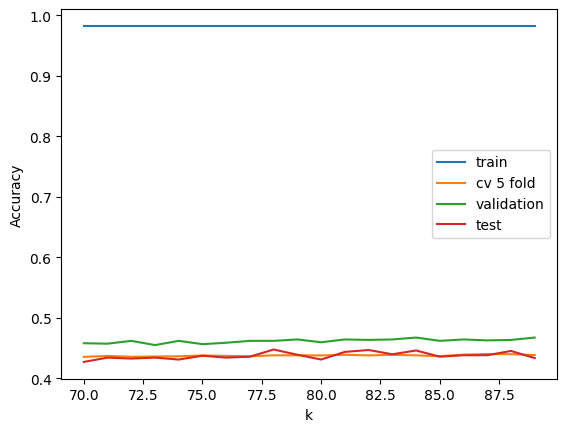

[[70.      42.69929]
 [71.      43.40963]
 [72.      43.25178]
 [73.      43.40963]
 [74.      43.09392]
 [75.      43.72534]
 [76.      43.40963]
 [77.      43.56748]
 [78.      44.75138]
 [79.      43.88319]
 [80.      43.09392]
 [81.      44.35675]
 [82.      44.67245]
 [83.      43.96212]
 [84.      44.59353]
 [85.      43.56748]
 [86.      43.80426]
 [87.      43.80426]
 [88.      44.5146 ]
 [89.      43.3307 ]]


In [90]:
if BuildfinalKNN:
    plt.plot(k_range, scores_train_final, label = 'train')
    plt.plot(k_range, score_cv_final, label = 'cv 5 fold')
    plt.plot(k_range, scores_final, label = 'validation')
    plt.plot(k_range, scores2_final, label = 'test')
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.show()
    print(np.transpose(np.array([k_range,np.around(scores2_final,7)*100])))

Training accuracy:  0.98310546875


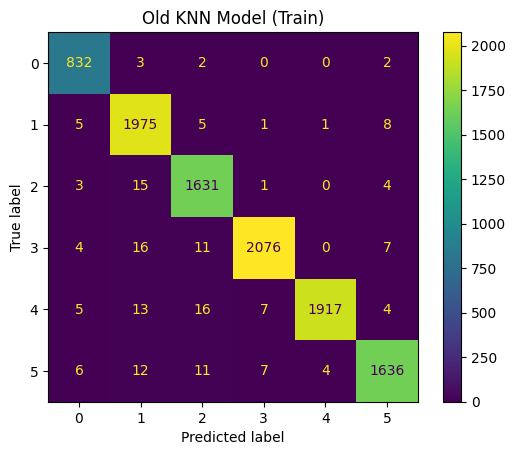

Validation accuracy:  0.45482866043613707


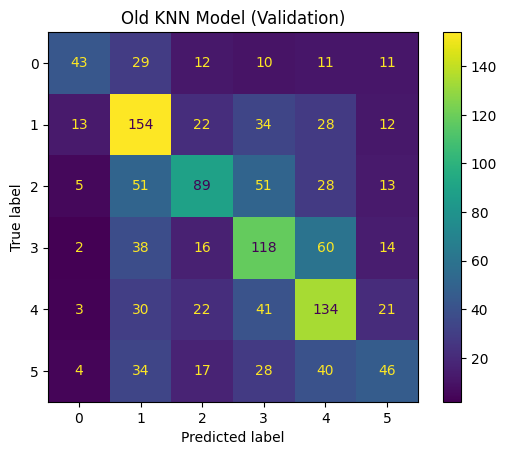

Test accuracy:  0.44751381215469616


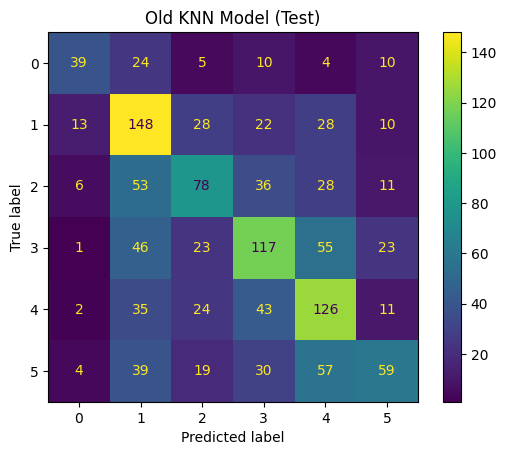

Training accuracy:  0.98271484375


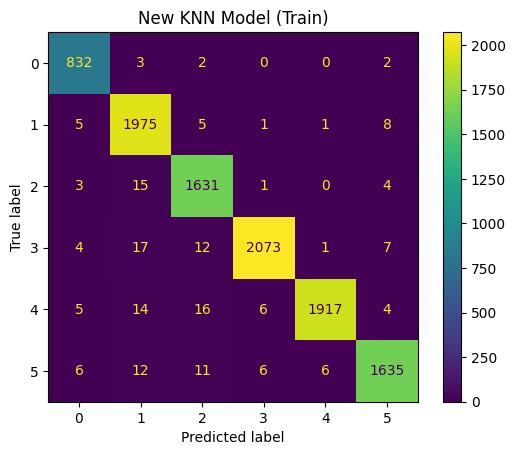

Validation accuracy:  0.4618380062305296


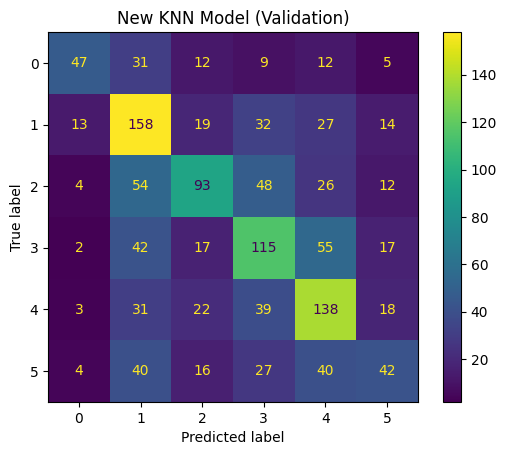

Test accuracy:  0.44751381215469616


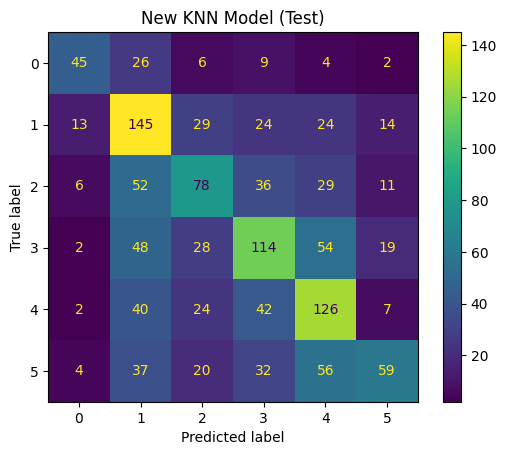

In [91]:
if BuildfinalKNN: 
    # old best k at k = 87
    knn = KNeighborsClassifier(n_neighbors=87,weights = 'distance')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_pred2 = knn.predict(X_v)
    y_pred3 = knn.predict(X_train)
    cm1 = confusion_matrix(y_test.iloc[:,label],y_pred[:,label], labels=knn.classes_[label])
    cm2 = confusion_matrix(y_v.iloc[:,label],y_pred2[:,label], labels=knn.classes_[label])
    cm3 = confusion_matrix(y_train.iloc[:,label],y_pred3[:,label], labels=knn.classes_[label])
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=knn.classes_[label])
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=knn.classes_[label])
    disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3,display_labels=knn.classes_[label])
    print("Training accuracy: ", metrics.accuracy_score(y_train.iloc[:,label], y_pred3[:,label]))
    disp3.plot()
    plt.title('Old KNN Model (Train)')
    plt.show()
    print("Validation accuracy: ", metrics.accuracy_score(y_v.iloc[:,label], y_pred2[:,label]))
    disp2.plot()
    plt.title('Old KNN Model (Validation)')
    plt.show()
    print("Test accuracy: ", metrics.accuracy_score(y_test.iloc[:,label], y_pred[:,label]))
    disp1.plot()
    plt.title('Old KNN Model (Test)')
    plt.show()
    
    
    # new best k at k = 78
    knn = KNeighborsClassifier(n_neighbors=78,weights = 'distance')
    knn.fit(X_train2, y_train)
    y_pred = knn.predict(X_test2)
    y_pred2 = knn.predict(X_v2)
    y_pred3 = knn.predict(X_train2)
    cm1 = confusion_matrix(y_test.iloc[:,label],y_pred[:,label], labels=knn.classes_[label])
    cm2 = confusion_matrix(y_v.iloc[:,label],y_pred2[:,label], labels=knn.classes_[label])
    cm3 = confusion_matrix(y_train.iloc[:,label],y_pred3[:,label], labels=knn.classes_[label])
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=knn.classes_[label])
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=knn.classes_[label])
    disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3,display_labels=knn.classes_[label])
    print("Training accuracy: ", metrics.accuracy_score(y_train.iloc[:,label], y_pred3[:,label]))
    disp3.plot()
    plt.title('New KNN Model (Train)')
    plt.show()
    print("Validation accuracy: ", metrics.accuracy_score(y_v.iloc[:,label], y_pred2[:,label]))
    disp2.plot()
    plt.title('New KNN Model (Validation)')
    plt.show()
    print("Test accuracy: ", metrics.accuracy_score(y_test.iloc[:,label], y_pred[:,label]))
    disp1.plot()
    plt.title('New KNN Model (Test)')
    plt.show()
    
    
    

We can see that we gain a significant improvement on the validation set after we remove the home state of the speaker. This coincides with our assumption. However, we now see a problem. This dataset could not be generalize at all. To elaborate, assume that a person is a representative from a specific party and tends to lie more, but when he/she becomes the president and he tends to lie less. While the model built from this dataset already pick up a signal from these two feature and may rule him/her out as a liar. Another example would be if once healthcare is a hot debate and there are fake information floating around, would statements about healtcare tend to be fake 2 or 3 years later?

In conclusion, with yet a tradition NLP and simple classification model, we can achieve accuracy exceeding one from the Yang paper [1]. However, we have some skepticism whether if this dataset ro dataset with similar structure would provide a meaningful method to deliver a generalizable model.